# 基于岭回归和SVM的模型融合回归模型

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [40]:
df = pd.read_excel('赛题附件\\附件1.xlsx')
df.columns

Index(['受试者编号', '研究开始时间', '研究结束时间', '性别', '年龄', '身高', '体重', 'ASA', '有无手术史',
       '手术说明',
       ...
       '如果有，那么是出现了腹腹痛', '如果有，那么是出现了腹都有', '有没出现腹胀腹痛的情况呢无', '还有没其他不舒服的情况呢有',
       '还有没其他不舒服的情况呢无', '术后24内患者的满意度评价非常满意', '术后24内患者的满意度评价满意',
       '术后24内患者的满意度评价一般', '术后24内患者的满意度评价不满意', '术后24内患者的满意度评价非常不满意'],
      dtype='object', length=185)

In [41]:
df1 = df[['性别','年龄','身高','体重','ASA','有无手术史','手术说明','有无既往史','既往史说明',
          '是否吸烟','是否酗酒','有无PONV','有无晕动史','镇静药名称','镇静药诱导剂量',
          '有无追加镇静','镇静追加次数','镇静药追加剂量','镇静追加2','镇静追加3','镇静追加4',
          '镇静药总剂量','镇痛药诱导剂量','有无追加镇痛','镇痛追加次数','镇痛药追加剂量','镇痛药总剂量',
          'IPI005','IPI1','IPI015','IPI2','IPI025','IPI3']]

# 找缺失值
a = df1.isnull().sum()

In [42]:
df1 = df1.drop(['手术说明', '既往史说明', '镇静追加次数','镇静药追加剂量',
                '镇静追加2','镇静追加3','镇静追加4', '镇痛追加次数','镇痛药追加剂量'], axis=1)

df1 = df1.drop(['ASA','有无PONV', '有无晕动史', '镇痛药诱导剂量'], axis=1)

# 直接删掉含有缺失值的单位
df2 = df1.dropna()

# 这个特征比例差别太大了，聚合一下
df2["是否吸烟"] = df2["是否吸烟"].map({"从未吸烟者": '不抽烟', 
                                    "经常吸烟者：每天吸卷烟1支以上，连续或累计6个月": '抽烟',
                                    "偶尔吸烟者：每周吸卷烟超过4次，但平均每天不足1支": '抽烟'})

C:\Users\Jack\AppData\Local\Temp\ipykernel_4192\4009870114.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["是否吸烟"] = df2["是否吸烟"].map({"从未吸烟者": '不抽烟',


In [43]:
# 数据归一化
model = MinMaxScaler()
df2[["年龄", "身高", "体重", '镇静药总剂量', '镇痛药总剂量', 'IPI005',
     'IPI1','IPI015','IPI2','IPI025','IPI3']] = \
        model.fit_transform(df2[["年龄", "身高", "体重", '镇静药总剂量', '镇痛药总剂量',
                                 'IPI005','IPI1','IPI015','IPI2','IPI025','IPI3']])

# 特征空间
X = df2.drop(['IPI005','IPI1','IPI015','IPI2','IPI025','IPI3'], axis=1)

# 编码
X["性别"] = X["性别"].map({"男": 1, "女": 0})
X["有无手术史"] = X["有无手术史"].map({"有": 1, "无": 0})
X["有无既往史"] = X["有无既往史"].map({"有": 1, "无": 0})
X["是否吸烟"] = X["是否吸烟"].map({"抽烟": 1, "不抽烟": 0})
X["是否酗酒"] = X["是否酗酒"].map({"有": 1, "无": 0})
X["镇静药名称"] = X["镇静药名称"].map({"B药": 1, "R药": 0})
X["镇静药诱导剂量"] = X["镇静药诱导剂量"].map({"1.5mg/kg": 1, "0.15mg/kg": 0})
X["有无追加镇静"] = X["有无追加镇静"].map({"有": 1, "无": 0})
X["有无追加镇痛"] = X["有无追加镇痛"].map({"有": 1, "无": 0})

C:\Users\Jack\AppData\Local\Temp\ipykernel_4192\2420879001.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[["年龄", "身高", "体重", '镇静药总剂量', '镇痛药总剂量', 'IPI005',


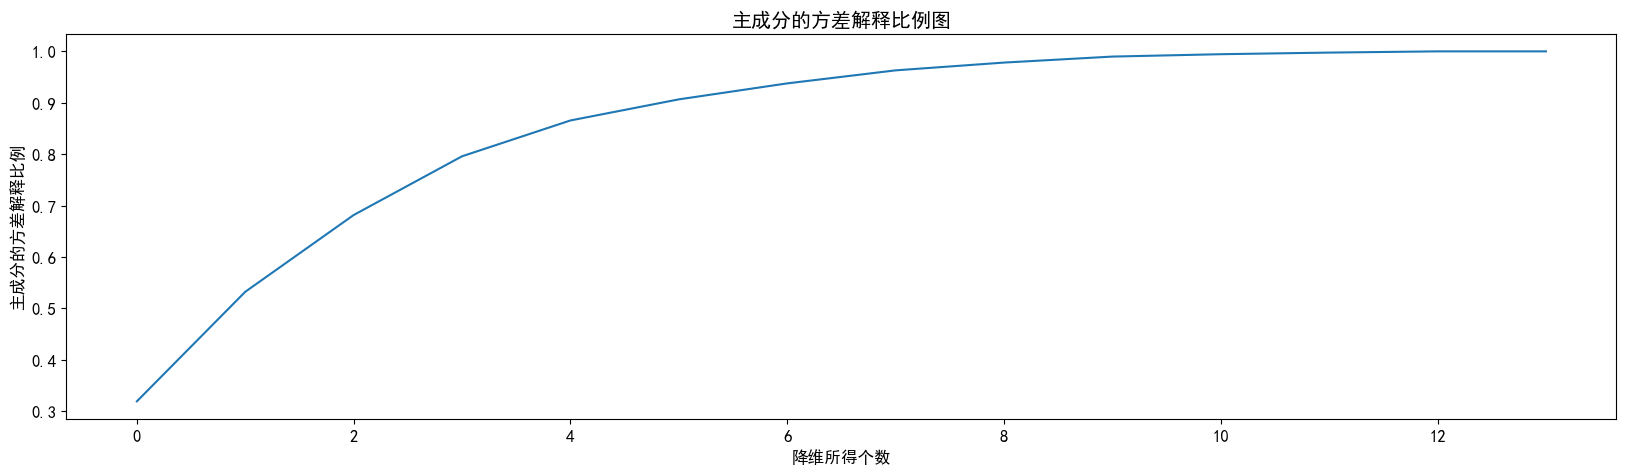

In [44]:
# 创建PCA对象并进行降维
pca = PCA(n_components=14)
X_try = pca.fit_transform(X)

# 绘制主成分方差解释比例图
plt.figure(figsize=(20, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('降维所得个数')
plt.ylabel('主成分的方差解释比例')
plt.title('主成分的方差解释比例图')
plt.show()

In [45]:
# 创建PCA对象并进行降维
pca = PCA(n_components=4)
X = pca.fit_transform(X)

# 开始预测

<br><br><br>

## 这是第一个，最重要，要把灵敏度分析给做了放在论文里

IPI005

In [46]:
y1 = df2.IPI005

# 划分数据集
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=0)

In [47]:
# 模型初始化
ridge = Ridge(alpha=1)
# 模型训练、模型预测
y1_pred1 = ridge.fit(X1_train, y1_train).predict(X1_test)
# Mean Squared Error（均方误差）
MSE_1 = mean_squared_error(y1_test, y1_pred1)
# Mean Absolute Error（平均绝对误差）
MAE_1 = mean_absolute_error(y1_test, y1_pred1)

print(MSE_1)
print(MAE_1)

0.042250765450243664
0.14465909516761744


In [48]:
# 支持向量机
svr = SVR(kernel='rbf')
# 模型训练、模型预测
y1_pred2 = svr.fit(X1_train, y1_train).predict(X1_test)
# Mean Squared Error（均方误差）
MSE_2 = mean_squared_error(y1_test, y1_pred2)
# Mean Absolute Error（平均绝对误差）
MAE_2 = mean_absolute_error(y1_test, y1_pred2)

print(MSE_2)
print(MAE_2)

0.04165962170874066
0.14178524900725717


In [49]:
w1 = 1 / MSE_1
w2 = 1 / MSE_2
w1_normalized = w1 / (w1 + w2)
w2_normalized = w2 / (w1 + w2)

y1_pred = w1_normalized * y1_pred1 + w2_normalized * y1_pred2

print(mean_squared_error(y1_test, y1_pred))
print(mean_absolute_error(y1_test, y1_pred))

0.04187482873707873
0.1432089209800375


c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\s

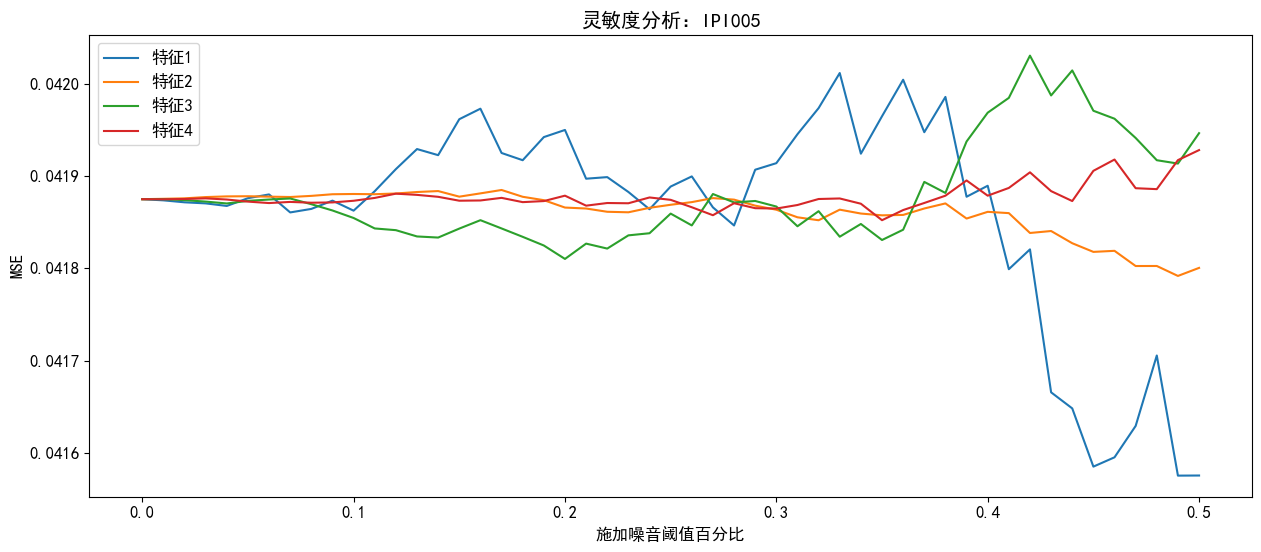

In [50]:
def analysis(X1_test):
    # 接受过噪音的X_test得分情况
    score_1, score_2, score_3, score_4 = [], [], [], []

    for j in range(0, 4):

        # 备份新的X_test用于噪音处理
        df1 = np.array(X1_test.copy())
        # 打印X_test的维数，方便后面做循环
        m, n = np.array(X1_test).shape
        # 噪音
        error = np.ones(shape=(m, 1))

        # 按0到0.5的比例对X_test进行噪音处理
        for i in np.linspace(0, 0.5, 51):

            # 施加对应比例噪音并添加到X_test上，产生新的测试集特征df2
            error[:, 0] = np.random.uniform(-i * df1[:, j], i * df1[:, j])
            df1[:, j] = df1[:, j] + error[:, 0]
            df2 = pd.DataFrame(df1)
            df2.columns = ['特征1', '特征2', '特征3', '特征4']

            # 构建完数据后预测、打分
            y_pred1 = pd.DataFrame(ridge.predict(df2))
            y_pred2 = pd.DataFrame(svr.predict(df2))
            MSE_1 = mean_squared_error(y1_test, y_pred1)
            MSE_2 = mean_squared_error(y1_test, y_pred2)

            w1 = 1 / MSE_1
            w2 = 1 / MSE_2
            w1_normalized = w1 / (w1 + w2)
            w2_normalized = w2 / (w1 + w2)

            y_pred = w1_normalized * y_pred1 + w2_normalized * y_pred2
        
            if j == 0:
                score_1.append(mean_squared_error(y1_test, y_pred))
            elif j == 1:
                score_2.append(mean_squared_error(y1_test, y_pred))
            elif j == 2:
                score_3.append(mean_squared_error(y1_test, y_pred))
            else:
                score_4.append(mean_squared_error(y1_test, y_pred))
    
    return score_1, score_2, score_3, score_4

score_1, score_2, score_3, score_4 = analysis(X1_test)

plt.figure(figsize=(15, 6))
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
plt.xlabel("施加噪音阈值百分比")
plt.ylabel("MSE")

plt.plot(np.linspace(0, 0.5, 51), score_1, label="特征1")
plt.plot(np.linspace(0, 0.5, 51), score_2, label="特征2")
plt.plot(np.linspace(0, 0.5, 51), score_3, label="特征3")
plt.plot(np.linspace(0, 0.5, 51), score_4, label="特征4")

plt.title("灵敏度分析：IPI005")
plt.legend()
plt.show()

IPI1

In [51]:
y1 = df2.IPI1

# 划分数据集
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=0)

In [52]:
# 模型初始化
ridge = Ridge(alpha=1)
# 模型训练、模型预测
y1_pred1 = ridge.fit(X1_train, y1_train).predict(X1_test)
# Mean Squared Error（均方误差）
MSE_1 = mean_squared_error(y1_test, y1_pred1)
# Mean Absolute Error（平均绝对误差）
MAE_1 = mean_absolute_error(y1_test, y1_pred1)

print(MSE_1)
print(MAE_1)

0.1020343559472265
0.23760230273627825


In [53]:
# 支持向量机
svr = SVR(kernel='rbf')
# 模型训练、模型预测
y1_pred2 = svr.fit(X1_train, y1_train).predict(X1_test)
# Mean Squared Error（均方误差）
MSE_2 = mean_squared_error(y1_test, y1_pred2)
# Mean Absolute Error（平均绝对误差）
MAE_2 = mean_absolute_error(y1_test, y1_pred2)

print(MSE_2)
print(MAE_2)

0.1152555373564523
0.2272219343614658


In [54]:
w1 = 1 / MSE_1
w2 = 1 / MSE_2
w1_normalized = w1 / (w1 + w2)
w2_normalized = w2 / (w1 + w2)

y1_pred = w1_normalized * y1_pred1 + w2_normalized * y1_pred2

print(mean_squared_error(y1_test, y1_pred))
print(mean_absolute_error(y1_test, y1_pred))

0.10662112912349647
0.23217228421186104


c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\s

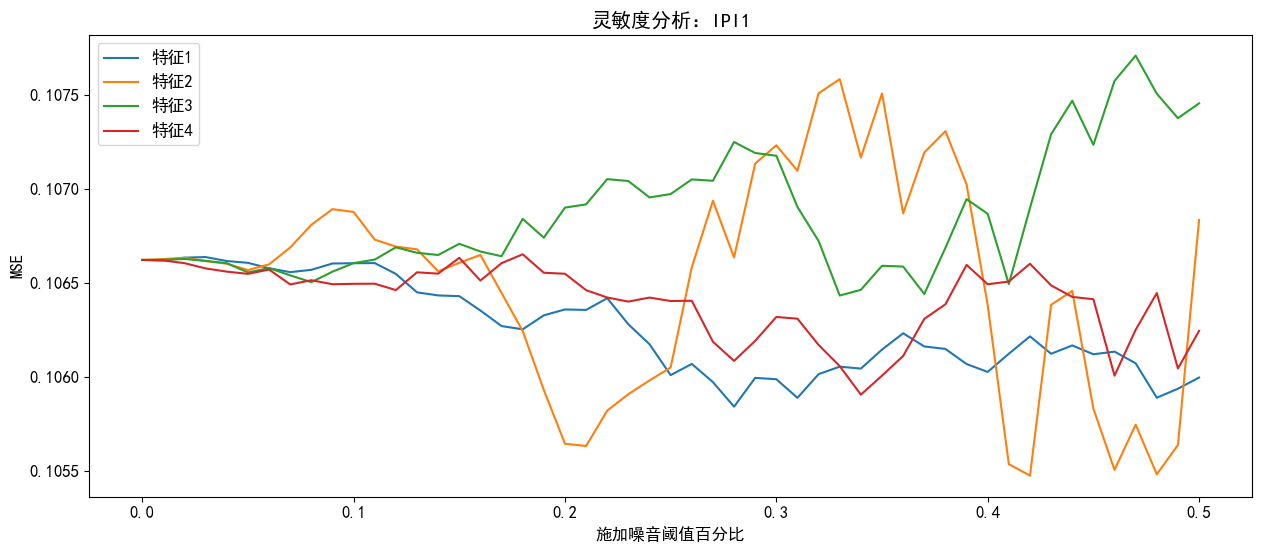

In [55]:
score_1, score_2, score_3, score_4 = analysis(X1_test)

plt.figure(figsize=(15, 6))
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
plt.xlabel("施加噪音阈值百分比")
plt.ylabel("MSE")

plt.plot(np.linspace(0, 0.5, 51), score_1, label="特征1")
plt.plot(np.linspace(0, 0.5, 51), score_2, label="特征2")
plt.plot(np.linspace(0, 0.5, 51), score_3, label="特征3")
plt.plot(np.linspace(0, 0.5, 51), score_4, label="特征4")

plt.title("灵敏度分析：IPI1")
plt.legend()
plt.show()

IPI015

In [56]:
y1 = df2.IPI015

# 划分数据集
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=0)

In [57]:
# 模型初始化：岭回归
ridge = Ridge(alpha=1)
# 模型训练、模型预测
y1_pred1 = ridge.fit(X1_train, y1_train).predict(X1_test)
# Mean Squared Error（均方误差）
MSE_1 = mean_squared_error(y1_test, y1_pred1)
# Mean Absolute Error（平均绝对误差）
MAE_1 = mean_absolute_error(y1_test, y1_pred1)

print(MSE_1)
print(MAE_1)

0.16297979335564633
0.3668794419021068


In [58]:
# 支持向量机
svr = SVR(kernel='rbf')
# 模型训练、模型预测
y1_pred2 = svr.fit(X1_train, y1_train).predict(X1_test)
# Mean Squared Error（均方误差）
MSE_2 = mean_squared_error(y1_test, y1_pred2)
# Mean Absolute Error（平均绝对误差）
MAE_2 = mean_absolute_error(y1_test, y1_pred2)

print(MSE_2)
print(MAE_2)

0.1807814156573929
0.35667317860932807


In [59]:
w1 = 1 / MSE_1
w2 = 1 / MSE_2
w1_normalized = w1 / (w1 + w2)
w2_normalized = w2 / (w1 + w2)

y1_pred = w1_normalized * y1_pred1 + w2_normalized * y1_pred2

print(mean_squared_error(y1_test, y1_pred))
print(mean_absolute_error(y1_test, y1_pred))

0.16514891121173036
0.3577946455835507


c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\s

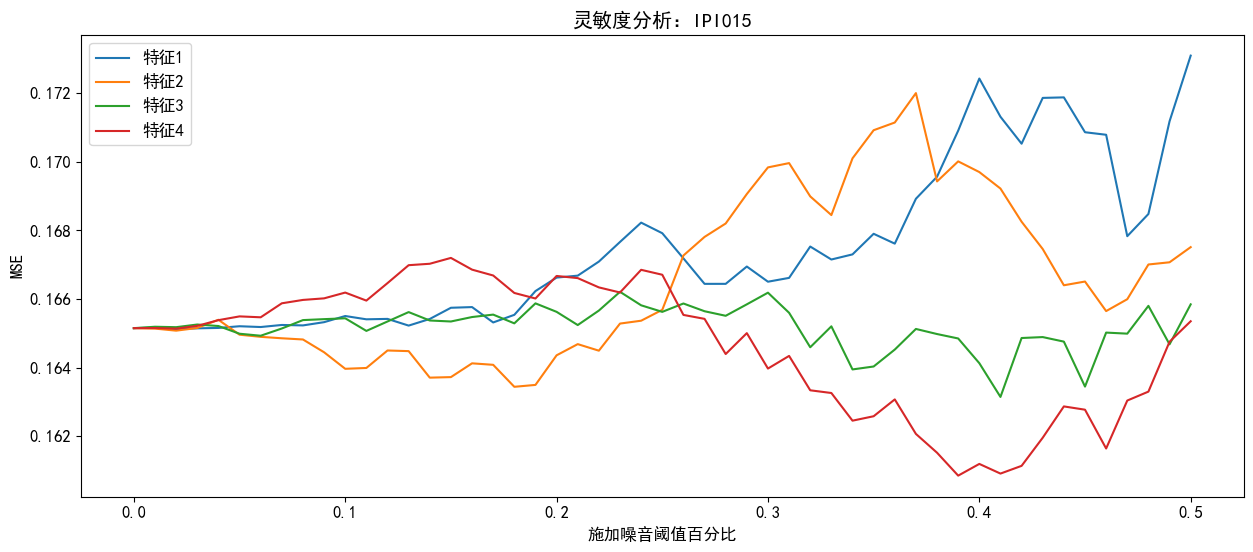

In [60]:
score_1, score_2, score_3, score_4 = analysis(X1_test)

plt.figure(figsize=(15, 6))
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
plt.xlabel("施加噪音阈值百分比")
plt.ylabel("MSE")

plt.plot(np.linspace(0, 0.5, 51), score_1, label="特征1")
plt.plot(np.linspace(0, 0.5, 51), score_2, label="特征2")
plt.plot(np.linspace(0, 0.5, 51), score_3, label="特征3")
plt.plot(np.linspace(0, 0.5, 51), score_4, label="特征4")

plt.title("灵敏度分析：IPI015")
plt.legend()
plt.show()

# <center>就用它！！！

IPI2

In [61]:
y1 = df2.IPI2

# 划分数据集
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=0)

In [62]:
# 模型初始化
ridge = Ridge(alpha=1)
# 模型训练、模型预测
y1_pred1 = ridge.fit(X1_train, y1_train).predict(X1_test)
# Mean Squared Error（均方误差）
MSE_1 = mean_squared_error(y1_test, y1_pred1)
# Mean Absolute Error（平均绝对误差）
MAE_1 = mean_absolute_error(y1_test, y1_pred1)

print(MSE_1)
print(MAE_1)

0.11031273440143037
0.26660444056014904


In [63]:
# 支持向量机
svr = SVR(kernel='rbf')
# 模型训练、模型预测
y1_pred2 = svr.fit(X1_train, y1_train).predict(X1_test)
# Mean Squared Error（均方误差）
MSE_2 = mean_squared_error(y1_test, y1_pred2)
# Mean Absolute Error（平均绝对误差）
MAE_2 = mean_absolute_error(y1_test, y1_pred2)

print(MSE_2)
print(MAE_2)

0.11744932151552627
0.23627004512357674


In [64]:
w1 = 1 / MSE_1
w2 = 1 / MSE_2
w1_normalized = w1 / (w1 + w2)
w2_normalized = w2 / (w1 + w2)

y1_pred = w1_normalized * y1_pred1 + w2_normalized * y1_pred2

print(mean_squared_error(y1_test, y1_pred))
print(mean_absolute_error(y1_test, y1_pred))

0.11010757001921284
0.25086671836321495


c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\s

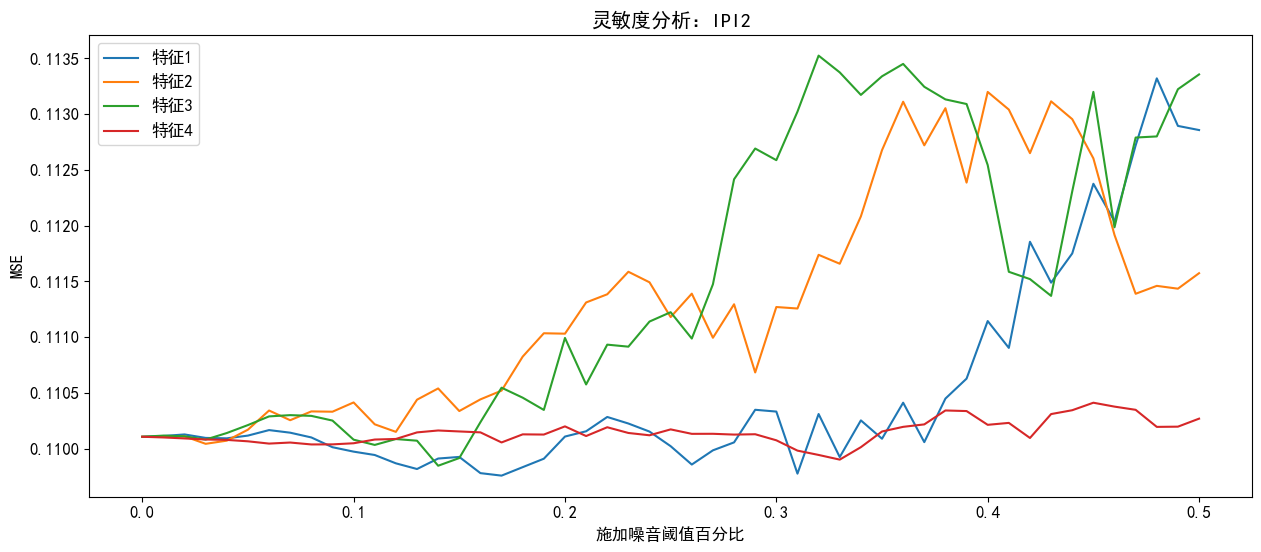

In [65]:
score_1, score_2, score_3, score_4 = analysis(X1_test)

plt.figure(figsize=(15, 6))
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
plt.xlabel("施加噪音阈值百分比")
plt.ylabel("MSE")

plt.plot(np.linspace(0, 0.5, 51), score_1, label="特征1")
plt.plot(np.linspace(0, 0.5, 51), score_2, label="特征2")
plt.plot(np.linspace(0, 0.5, 51), score_3, label="特征3")
plt.plot(np.linspace(0, 0.5, 51), score_4, label="特征4")

plt.title("灵敏度分析：IPI2")
plt.legend()
plt.show()

IPI025

In [66]:
y1 = df2.IPI025

# 划分数据集
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=0)

In [67]:
# 模型初始化
ridge = Ridge(alpha=1)
# 模型训练、模型预测
y1_pred1 = ridge.fit(X1_train, y1_train).predict(X1_test)
# Mean Squared Error（均方误差）
MSE_1 = mean_squared_error(y1_test, y1_pred1)
# Mean Absolute Error（平均绝对误差）
MAE_1 = mean_absolute_error(y1_test, y1_pred1)

print(MSE_1)
print(MAE_1)

0.06791389505698299
0.1679916763176843


In [68]:
# 支持向量机
svr = SVR(kernel='rbf')
# 模型训练、模型预测
y1_pred2 = svr.fit(X1_train, y1_train).predict(X1_test)
# Mean Squared Error（均方误差）
MSE_2 = mean_squared_error(y1_test, y1_pred2)
# Mean Absolute Error（平均绝对误差）
MAE_2 = mean_absolute_error(y1_test, y1_pred2)

print(MSE_2)
print(MAE_2)

0.06816808167861427
0.1663273708226738


In [69]:
w1 = 1 / MSE_1
w2 = 1 / MSE_2
w1_normalized = w1 / (w1 + w2)
w2_normalized = w2 / (w1 + w2)

y1_pred = w1_normalized * y1_pred1 + w2_normalized * y1_pred2

print(mean_squared_error(y1_test, y1_pred))
print(mean_absolute_error(y1_test, y1_pred))

0.06777813705034016
0.16706554191530687


c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\s

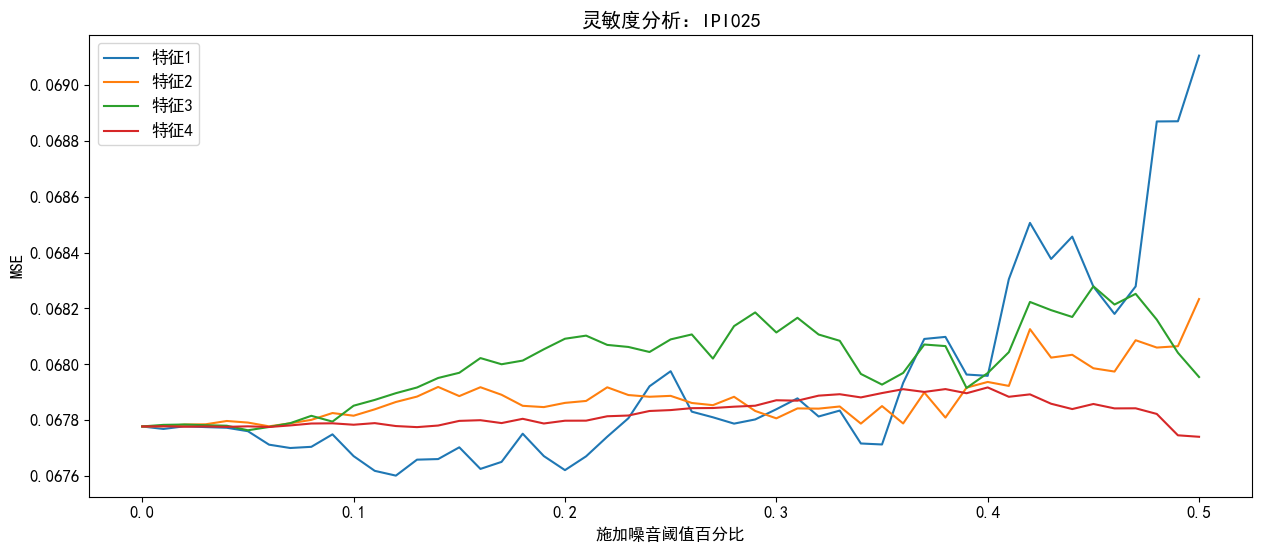

In [70]:
score_1, score_2, score_3, score_4 = analysis(X1_test)

plt.figure(figsize=(15, 6))
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
plt.xlabel("施加噪音阈值百分比")
plt.ylabel("MSE")

plt.plot(np.linspace(0, 0.5, 51), score_1, label="特征1")
plt.plot(np.linspace(0, 0.5, 51), score_2, label="特征2")
plt.plot(np.linspace(0, 0.5, 51), score_3, label="特征3")
plt.plot(np.linspace(0, 0.5, 51), score_4, label="特征4")

plt.title("灵敏度分析：IPI025")
plt.legend()
plt.show()

IPI3

In [71]:
y1 = df2.IPI3

# 划分数据集
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=0)

In [72]:
# 模型初始化
ridge = Ridge(alpha=1)
# 模型训练、模型预测
y1_pred1 = ridge.fit(X1_train, y1_train).predict(X1_test)
# Mean Squared Error（均方误差）
MSE_1 = mean_squared_error(y1_test, y1_pred1)
# Mean Absolute Error（平均绝对误差）
MAE_1 = mean_absolute_error(y1_test, y1_pred1)

print(MSE_1)
print(MAE_1)

0.07980071707829996
0.18099307653660326


In [73]:
# 支持向量机
svr = SVR(kernel='rbf')
# 模型训练、模型预测
y1_pred2 = svr.fit(X1_train, y1_train).predict(X1_test)
# Mean Squared Error（均方误差）
MSE_2 = mean_squared_error(y1_test, y1_pred2)
# Mean Absolute Error（平均绝对误差）
MAE_2 = mean_absolute_error(y1_test, y1_pred2)

print(MSE_2)
print(MAE_2)

0.08103368769500383
0.1788330764914977


In [74]:
w1 = 1 / MSE_1
w2 = 1 / MSE_2
w1_normalized = w1 / (w1 + w2)
w2_normalized = w2 / (w1 + w2)

y1_pred = w1_normalized * y1_pred1 + w2_normalized * y1_pred2

print(mean_squared_error(y1_test, y1_pred))
print(mean_absolute_error(y1_test, y1_pred))

0.07997951283019607
0.17970640054463016


c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
c:\Users\Jack\.conda\envs\ml\lib\s

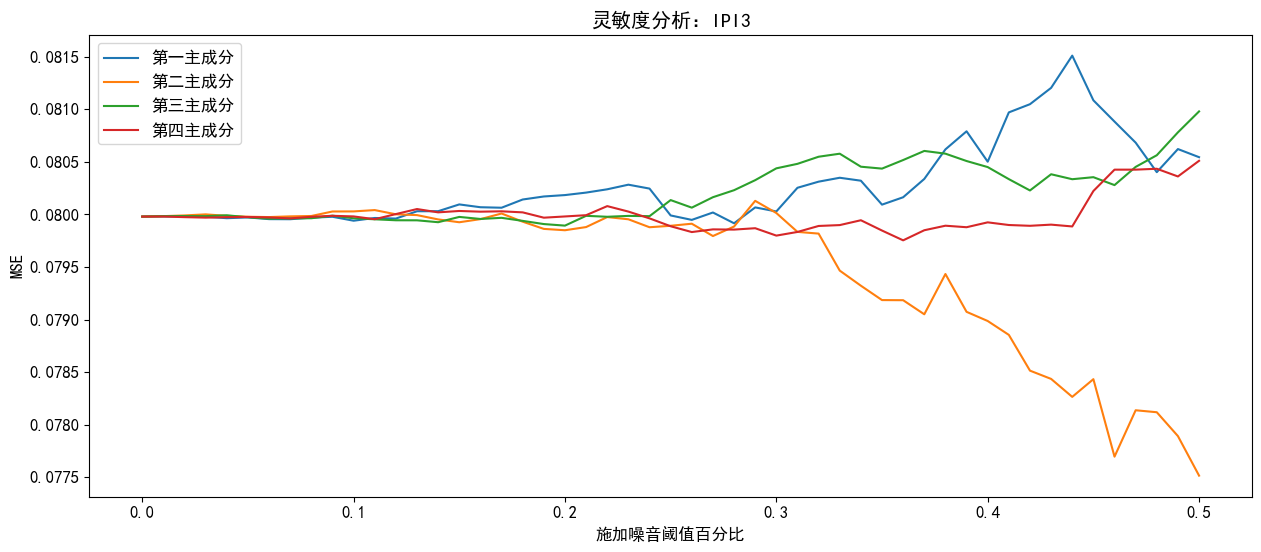

In [76]:
score_1, score_2, score_3, score_4 = analysis(X1_test)

plt.figure(figsize=(15, 6))
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
plt.xlabel("施加噪音阈值百分比")
plt.ylabel("MSE")

plt.plot(np.linspace(0, 0.5, 51), score_1, label="第一主成分")
plt.plot(np.linspace(0, 0.5, 51), score_2, label="第二主成分")
plt.plot(np.linspace(0, 0.5, 51), score_3, label="第三主成分")
plt.plot(np.linspace(0, 0.5, 51), score_4, label="第四主成分")

plt.title("灵敏度分析：IPI3")
plt.legend()
plt.show()